In [77]:
import random
import buildNetwork
import basicRunDORA
import pdb
import numpy as np
import seaborn as sns
NUM_ANALOGS = 4
N_COMPONENTS = 10
PER_ANALOG = 5
REPETITIONS = 10

In [86]:
parameters = {'asDORA': True, 'gamma': 0.3,
              'delta': 0.05, 'eta': 0.9,
              'HebbBias': 0.5,
              'bias_retrieval_analogs': False, 'use_relative_act': False, # Changeeeeddd!!!!!!!!
              #'run_order': ['cdr', 'selectTokens', 'r', 'wp', 'm', 'p', 's', 'f', 'c'],
              'run_order': ['cdr', 'selectTokens', 'r', 'm','c'],
              'run_cyles': 100, 'write_on_iteration': 100, 'firingOrderRule': 'in_order',
              'dim_list':[],
              'strategic_mapping': True, 'ignore_object_semantics': False,
              'ignore_memory_semantics': True, 'mag_decimal_precision': 0,
              'exemplar_memory': False, 'recent_analog_bias': True,
              'lateral_input_level': 1, 'screen_width': 1200, 'screen_height': 700,
              'doGUI': False, 'testing': True, 'GUI_update_rate': 50, 'starting_iteration': 0,
              'tokenize': False, 'ho_sem_act_flow': 0, 'remove_uncompressed': False, 'remove_compressed': False,
              'num_choose':10,'one_to_one':True,'max_norm':True, 'filename':'karthikeya/test_sim_custom-cbow-7-empty_pred.py',
             'len_regularisation':1, 'count_by_RBs':False, 'parent_bias':0.1, 'order_activation_bias':0.5,
             'results':'karthikeya/data/results/cbow.pkl'}

In [69]:
def init_network(parameters):
    reload(buildNetwork)
    reload(basicRunDORA)
    fileName = parameters['filename']
    f = open(fileName, 'r')
    simType = ''
    d = {'simType': simType}
    f.seek(0)
    exec (f.readline())
    if simType == 'sym_file':
        symstring = ''
        for line in f:
            symstring += line
        exec(symstring)
    # initialise memory
    memory = buildNetwork.initializeMemorySet()
    # interpret sym file
    mysym = buildNetwork.interpretSymfile(symProps)
    # build the network
    memory = basicRunDORA.dataTypes.memorySet()
    memory = buildNetwork.buildTheNetwork(mysym[0], memory)
    network = basicRunDORA.runDORA(memory, parameters)
    memory = basicRunDORA.update_memory_with_levels(memory)
    # run cycles
    # initialise mapping adjacency matrix:
    mapping_adj = np.zeros((len(network.memory.Ps), len(network.memory.Ps)))
    return [network, memory, mapping_adj]

In [70]:
def vis_mappings(mapping_mat, prop_names):
    sns_heatmap = sns.heatmap(mapping_mat, linewidth=0.5,xticklabels=prop_names, yticklabels=prop_names)
    fig = sns_heatmap.get_figure()
    return

In [71]:
def mapping_error(mapping_mat):
    # assuming an even split - NUM_ANALOGS * PER_ANALOG = number of analogs, number of propositions per analog
    # the mapping matrix is ordered by propositions, therefore every n%PER_ANALOG should be mapped together.
    # the mapping_mat is L1 normalised, and so the target matrix should contain values = 1.0/(NUM_ANALOGS - 1)
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1.0/(NUM_ANALOGS - 1)
    mapping_mat = mapping_mat * (target_mat > 0) # keep only diagonals for comparisons
    error_mat = (mapping_mat - target_mat)**2
    error_val = np.sqrt(np.mean(error_mat))
    return error_val

In [72]:
def get_metrics(mapping_mat):
    # mapping_mat contains the predicted mappings
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1
    # target_mat contains the true mappings in boolean values
    # Get True Positives (TP)
    true_positives = sum(sum(mapping_mat * target_mat))
    # False Positives (FP) 
    false_positives =  sum(np.sum(mapping_mat * abs(target_mat-1), axis=0))# gives all those non-zero mappings at the wrong place.
    # False Negatives (FN) giving zero mapping when it should actually be non zero
    false_negatives = sum(np.sum(mapping_mat * abs(target_mat-1), axis=1)) 
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives) 
    f_score = (2 * precision * recall) / (precision + recall)
    rmse = mapping_error(mapping_mat)
    return precision, recall, f_score, rmse

In [ ]:
# networ, memory, mapping_adj = init_network()
for cycle in range(parameters['run_cyles']):
    print('\n\n************************* Cycle: ' + str(cycle+1))

    # clear driver and recipient
    network.memory = basicRunDORA.clearDriverSet(network.memory)
    network.memory = basicRunDORA.clearRecipientSet(network.memory)

    # put the randomly chosen proposition in the driver
    proposition = random.sample(network.memory.Ps,k=parameters['num_choose']) # currently three propositions
    if parameters['num_choose'] > 1:
        proposition_num = []
        for p in proposition:
            proposition_num.append(network.memory.Ps.index(p))
    else:
        proposition_num = network.memory.Ps.index(proposition)

    if parameters['num_choose'] > 1:
        for p_num in proposition_num:
            network.memory = basicRunDORA.add_tokens_to_set(network.memory, p_num, 'P', 'driver')
    else:
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, proposition_num, 'P', 'driver')



    # make sure the driver and the recipient are set
    network.memory = basicRunDORA.findDriverRecipient(network.memory)
    network.do_map()

    # display ALL mappings
    #pdb.set_trace()
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            map_weight = mapping.weight
            if map_weight > 0:
                map_unit = mapping.recipientToken
                if mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] < 0.1:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
                else:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = (map_weight + 
                        mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)])/2.0 # DIRTY SOLUTION FOR NOW
            #print str(network.memory.Ps.index(myP)) + str(' -- ') + str(network.memory.Ps.index(map_unit)) + str(' : ') + str(map_weight)
    # display mappings
    print('\n\nMappings:\n')
    basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

In [73]:
def print_map_connections(network):
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            print myP.name, mapping.recipientToken.name, mapping.weight

In [ ]:
simulated_data = {}
for repetition in range(REPETITIONS):
    network, memory, mapping_adj = init_network(parameters)
    precisions, recalls, fscores, rmses = [],[],[],[]
    for cycle in range(parameters['run_cyles']):
        print('\n\n************************* Cycle: ' + str(cycle+1))
        #pdb.set_trace()
        # clear driver and recipient
        network.memory = basicRunDORA.clearDriverSet(network.memory)
        network.memory = basicRunDORA.clearRecipientSet(network.memory)
        # choose random analog from memory
        analog = random.choice(network.memory.analogs) # currently only one analog
        # choose random propositions from memory

        # put the analog in the driver
        analog_num = network.memory.analogs.index(analog)
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, analog_num, 'analog', 'driver')
        # retrieve analogs similar to one in the driver from LTM
        network.memory = basicRunDORA.findDriverRecipient(network.memory)
        network.do_retrieval()
        network.memory = basicRunDORA.findDriverRecipient(network.memory)

        #print('In driver : ' + network.memory.driver.Ps[0].name[1])
        #if len(network.memory.recipient.Ps) > 0:
        #    print('In recipient : ' + network.memory.recipient.Ps[0].name[1])
        #    if network.memory.recipient.Ps[0].name[1] == '3':
        #        network.do_map()
        #        print('\n\nMappings:\n')
        #        basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

        if len(network.memory.recipient.Ps) > 0: 
            print 'retrieval successful'
            # map the analogs in driver and recipient
            network.do_map()
            # display ALL mappings
            # display mappings
            print('\n\nMappings:\n')
            basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=False, only_max=False)
            # store all mappings : 
            for myP in network.memory.driver.Ps:
                for mapping in myP.mappingConnections:
                    map_weight = mapping.weight
                    map_unit = mapping.recipientToken
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
        # append rmse to list to keep track of RMSE evolution
        temp_mapping_adj  = mapping_adj
        for ind in range(temp_mapping_adj.shape[0]):
            if sum(temp_mapping_adj[ind,:]) > 0:
                temp_mapping_adj[ind,:] = temp_mapping_adj[ind,:]/sum(temp_mapping_adj[ind,:])    
        prec,rec,fsc,rmse = get_metrics(temp_mapping_adj)
        precisions.append(prec)
        recalls.append(rec)
        fscores.append(fsc)
        rmses.append(rmse)

    # normalise mappings
    for ind in range(mapping_adj.shape[0]):
        if sum(mapping_adj[ind,:]) > 0:
            mapping_adj[ind,:] = mapping_adj[ind,:]/sum(mapping_adj[ind,:])
    simulated_data[repetition] = [fscores,rmses,mapping_adj]



************************* Cycle: 1
retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- P25 -- mapping_weight=', 0.5730620395195236)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P25.2 -- mapping_weight=', 0.08500401497767973)
('P: P14 -- P27 -- mapping_weight=', 0.3308021438625409)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atstrangers -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.0834953749405099)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 1)
('RB: hissobj -- hissobj -- mapping_weight=', 1)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: slithero

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.0834953749405099)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 1)
('RB: hissobj -- hissobj -- mapping_weight=', 1)
('RB: detsnakes -- NONE -- mapping

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P25 -- mapping_weight=', 0.5730620395195236)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P06 -- mapping_weight=', 0.3819958408927805)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- bitecats -- mapping_weight=', 0.002050826353312638)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atstra

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P06 -- mapping_weight=', 0.3819958408927805)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- bitecats -- mapping_weight=', 0.002050826353312638)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atstrange

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P06 -- mapping_weight=', 0.3819958408927805)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- purrsoftly -- mapping_weight=', 0.0026014260505449276)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atstran

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P01 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P04 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8021236644226445)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P07 -- P07 -- mapping_weight=', 0.03014325848592669)
('RB: detdogs -- flyobj -- mapping_weight=', 0.057894911540773863)
('RB: chasecats -- chasecats -- mapping_weight=', 0.43436528999046253)
('RB: hungrydogs -- NONE -- mapping_weight='

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P06 -- mapping_weight=', 0.3819958408927805)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- purrsoftly -- mapping_weight=', 0.0026014260505449276)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atstran

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.2628271073818707)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mappi

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- detlions -- mapping_weight=', 0.00771602869560868)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.48178383118810614)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mapp

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- detlions -- mapping_weight=', 0.00771602869560868)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.48178383118810614)
('RB: angry

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9592157915922628)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P24 -- P24 -- mapping_weight=', 0.6866324791107422)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.08500401497767973)
('P: P25 -- P25 -- mapping_weight=', 0.5730620395195236)
('P: P26.1 -- P37.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P27 -- P27 -- mapping_weight=', 0.6980480518551982)
('RB: deteagles -- deteagles -- mapping_weight=', 0.844622790363192)
('RB: eatworms -- smallcats -- mapping_weight=', 0.624737927699012)
('RB: majesticeagles -- m

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mapp

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- detlions -- mapping_weight=', 0.00771602869560868)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.48178383118810614)
('RB: angry



************************* Cycle: 53
retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('



************************* Cycle: 57


************************* Cycle: 58
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P01 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P02 -- P02 -- mapping_weight=', 0.27605073960014764)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P04 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8021236644226445)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P07 -- P07 -- mapping_weight=', 0.71778028962039)
('RB: detdogs -- detdogs -- mapping_weight=', 0.28816255243005584)
('RB: chasecats -- chasecat

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mapp

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mapp

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- detlions -- mapping_weight=', 0.00771602869560868)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.48178383118810614)
('RB: angry



************************* Cycle: 73
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9592157915922628)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P24 -- P07 -- mapping_weight=', 0.71778028962039)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.08500401497767973)
('P: P25 -- P25 -- mapping_weight=', 0.5730620395195236)
('P: P26.1 -- P37.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P27 -- P27 -- mapping_weight=', 0.7449609866783421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.844622790363192)
('RB: eatworms -- smallcats -- mapping_weight=', 0.624737



************************* Cycle: 77
retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.023417043421337984)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P01 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P02 -- P02 -- mapping_weight=', 0.3569329084043662)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P04 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8021236644226445)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P07 -- P07 -- mapping_weight=', 0.71778028962039)
('RB: detdogs -- detdogs -- mapping_weight=', 0.28816255243005584)
('RB: chasecats -- chasecats -- mapping_weight=', 0.4384210083802397)
('RB: hungrydogs -- hungrydogs -- 

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9592157915922628)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P24 -- P37 -- mapping_weight=', 0.7183832265254338)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.08500401497767973)
('P: P25 -- P25 -- mapping_weight=', 0.6849538119845813)
('P: P26.1 -- P37.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P27 -- P27 -- mapping_weight=', 0.7449609866783421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.844622790363192)
('RB: eatworms -- smallcats -- mapping_weight=', 0.624737927699012)
('RB: majesticeagles -- m

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P01 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P02 -- P02 -- mapping_weight=', 0.3569329084043662)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P04 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8021236644226445)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P07 -- P07 -- mapping_weight=', 0.71778028962039)
('RB: detdogs -- detdogs -- mapping_weight=', 0.28816255243005584)
('RB: chasecats -- chasecats -- mapping_weight=', 0.4384210083802397)
('RB: hungrydogs -- hungrydogs -- 

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P11 -- P01 -- mapping_weight=', 0.5896381751843315)
('P: P12 -- P00 -- mapping_weight=', 0.4841586980401951)
('P: P13.1 -- P03.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P04 -- mapping_weight=', 0.8371445656363737)
('P: P15.1 -- P05.2 -- mapping_weight=', 0.6369093833558842)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.15986269017232047)
('P: P15 -- P05 -- mapping_weight=', 1)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P16.2 -- P25.1 -- mapping_weight=', 0.02410729387064183)
('P: P16 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P17.1 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P17 -- P34 -- mapping_weight=', 0.9792122183712161)
('RB: detlions -- detlions -- mapping_weight=', 0.00771602869560868)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.48178383118810614)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.3934721354308717)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.725732238668639)
('P: P34 -- P34 -- mapping_weight=', 0.9792122183712161)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.15771223130714018)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.7990161343690786)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.0679678869332504)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4212036923555943)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.7183832265254338)
('RB: detsnakes -- biglions -- mapping_weight=', 0.0009416484969388884)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7319673325584077)
('RB: angrysnakes -- angrysnakes -- mappin

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.35820513104206836)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P06.2 -- mapping_weight=', 0.8619200424442233)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9592157915922628)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 0.40891128981891234)
('P: P24 -- P37 -- mapping_weight=', 0.7183832265254338)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.7302853964679697)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.13845823240718724)
('P: P25 -- P25 -- mapping_weight=', 0.6849538119845813)
('P: P26.1 -- P37.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.8380875610968067)
('P: P27 -- P27 -- mapping_weight=', 0.7449609866783421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.844622790363192)
('RB: eatworms -- smallcats -- mapping_weight=', 0.624737927699012)
('RB: majesticeagles -- m

C:\Users\karkau\AppData\Local\Continuum\anaconda2\envs\Dora\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- NONE -- mapping_weight=', 0.0)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P14 -- mapping_weight=', 0.6479558389342457)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE -- mapping_weight=', 0.0)
('RB: jumpobj -- NON

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- NONE -- mapping_weight=', 0.0)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- P14 -- mapping_weight=', 0.6479558389342457)
('RB: detsnakes -- glideobj -- mapping_weight=', 0.0007045801636908545)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- NONE -- mapping_weight=', 0.0)
('RB: hissobj -- NONE -- mapping

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P14 -- mapping_weight=', 0.6479558389342457)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE -- mapping_weigh

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.2577631902840203)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P05 -- mapping_weight=', 0.6722313905081596)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- eatrats -- mapping_weight=', 0.18172945965940004)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB:

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- P16 -- mapping_weight=', 0.13258113589716553)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- detdeer -- mapping_weight=', 0.0023492635490468456)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- majesticeagles -- mapping_weight=', 0.5090641090870579)
('RB: 

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P25.2 -- mapping_weight=', 0.021099914453882523)
('P: P37 -- P14 -- mapping_weight=', 0.6479558389342457)
('RB: detsnakes -- barkobj -- mapping_weight=', 0.001726112624724653)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mappi

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.2577631902840203)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.376768101816093)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- towardstraps -- mapping_weight=', 0.2683600458641041)
('RB: roarobj -- NONE -- mapping_wei

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.08117356016596705)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- detdeer -- mapping_weight=', 0.0023492635490468456)
('RB: eatworms -- bitecats -- mapping_weight=', 0.015616680379746804)
('RB: majesticeagles -- majesticeagl

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.08117356016596705)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- detdeer -- mapping_weight=', 0.0023492635490468456)
('RB: eatworms -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: majesticeagles -- 

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.1351375485456745)
('P: P01 -- P21 -- mapping_weight=', 0.5838044198498992)
('P: P02 -- P02 -- mapping_weight=', 0.2577631902840203)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P04 -- P27 -- mapping_weight=', 0.8253013019010691)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P05 -- P05 -- mapping_weight=', 0.6722313905081596)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P06.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P06 -- P36 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- flyobj -- mapping_weight=', 0.024111968952239448)
('RB: chasecats -- wanderaimlessly -- mapping_weight=', 0.3744461

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.1351375485456745)
('P: P01 -- P21 -- mapping_weight=', 0.5838044198498992)
('P: P02 -- P02 -- mapping_weight=', 0.27163903271014445)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P04 -- P27 -- mapping_weight=', 0.8253013019010691)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P05 -- P05 -- mapping_weight=', 0.6722313905081596)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P06.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P06 -- P36 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- flyobj -- mapping_weight=', 0.024111968952239448)
('RB: chasecats -- wanderaimlessly -- mapping_weight=', 0.374446



************************* Cycle: 39
retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10404329592654853)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7131748968314191)
('RB: eatworms -- eatrats -- mapping_weight=', 0.441505

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10404329592654853)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7131748968314191)
('RB: eatworms -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: majesticeagles -- m

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.2577631902840203)
('P: P11 -- P11 -- mapping_weight=', 0.02098182121533578)
('P: P12 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.376768101816093)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.010890523856083734)
('RB: angrylions -- towardstraps -- mapping_weight=', 0.2683

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10404329592654853)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7131748968314191)
('RB: eatworms -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: majesticeagles -- c

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.2577631902840203)
('P: P11 -- P11 -- mapping_weight=', 0.37607609415971255)
('P: P12 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.37770043222661126)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.010890523856083734)
('RB: angrylions -- spottedsnakes -- mapping_weight=', 0.4

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.2611053480006393)
('P: P01 -- P21 -- mapping_weight=', 0.5838044198498992)
('P: P02 -- P02 -- mapping_weight=', 0.2827975141612915)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P04 -- P27 -- mapping_weight=', 0.8253013019010691)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P05 -- P05 -- mapping_weight=', 0.679733831292051)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P06.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P06 -- P36 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5162686876062424)
('RB: hungrydo

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.3405996997507808)
('P: P11 -- P11 -- mapping_weight=', 0.37607609415971255)
('P: P12 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.025733678567305924)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.37770043222661126)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.0437277089391994)
('RB: angrylions -- spottedsnakes -- mapping

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.3405996997507808)
('P: P11 -- P11 -- mapping_weight=', 0.6186129319389163)
('P: P12 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6729235257137535)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.37770043222661126)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.0437277089391994)
('RB: angrylions -- spottedsnakes -- mapping_we



************************* Cycle: 81
retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10404329592654853)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.3405996997507808)
('P: P11 -- P11 -- mapping_weight=', 0.6186129319389163)
('P: P12 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P14 -- P04 -- mapping_weight=', 0.7313315259599524)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P15.2 -- P26.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6729235257137535)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.37770043222661126)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.0437277089391994)
('RB: angrylions -- spottedsnakes -- mapping_we

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.2611053480006393)
('P: P01 -- P21 -- mapping_weight=', 0.5838044198498992)
('P: P02 -- P02 -- mapping_weight=', 0.317190238614003)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P04 -- P27 -- mapping_weight=', 0.8253013019010691)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P05 -- P05 -- mapping_weight=', 0.679733831292051)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P06.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P06 -- P36 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5584574139721524)
('RB: hungrydog

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.2611053480006393)
('P: P01 -- P21 -- mapping_weight=', 0.5838044198498992)
('P: P02 -- P02 -- mapping_weight=', 0.33542282451984173)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P04 -- P27 -- mapping_weight=', 0.8253013019010691)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.41609499605829064)
('P: P05 -- P05 -- mapping_weight=', 0.7569534947911044)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P06.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P06 -- P36 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8796570423340729)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9524165980100372)
('RB: hungry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P12 -- mapping_weight=', 0.4649338947656766)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8990728290317972)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.8759369583362855)
('P: P34 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.8810104330721904)
('P: P35 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P36.1 -- P14.1 -- mapping_weight=', 0.9301754350584577)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.04051904951819305)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04405338975433374)
('P: P37 -- P37 -- mapping_weight=', 0.7631328080436827)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: angrys

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.7147141777751749)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P13.1 -- mapping_weight=', 1)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9649544679978264)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6688645726581717)
('P: P24 -- P24 -- mapping_weight=', 0.9268768373382208)
('P: P25.1 -- P05.1 -- mapping_weight=', 0.6982982907808228)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.41927940276392706)
('P: P25 -- P25 -- mapping_weight=', 0.8923809246993858)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P13 -- mapping_weight=', 0.8800371166893199)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10404329592654853)
('P: P27 -- P27 -- mapping_weight=', 0.8253013019010691)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatrats -- mapping_weight=', 0.44150508111491427)
('RB: majesticeagles -- chasecats -- mappi

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P01 -- P23.1 -- mapping_weight=', 0.7162412108339804)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P27 -- mapping_weight=', 0.667793371374465)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P26.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- slitherobj -- mapping_weight=', 0.9407019542220966)
('RB: hungrydogs -- hungrydogs -- mapping_weight=', 0.010226489278122334)
('RB: barkobj -- NONE -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P31 -- mapping_weight=', 0.04292596829109027)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.010832658321919398)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- NONE -- mapping_weight=', 0.0)
('RB: hissobj -- NONE -- mapping_weig

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- huntdeer -- mapping_weight=', 0.0011839989133359142)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj -- mapping_weight=', 0.17349562791159281)


retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- huntdeer -- mapping_weight=', 0.0011839989133359142)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj -- mapping_



************************* Cycle: 16
retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P25.2 -- mapping_weight=', 0.036466752446194614)
('P: P14 -- P05 -- mapping_weight=', 0.7065960355996337)
('P: P15.1 -- P05.1 -- mapping_weight=', 0.04451075278175892)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weigh

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.2659768425047148)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.25416310289851574)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.667793371374465)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: majesticeagles -- bigsnakes -- mapping

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- dullworms -- mapping_weight=', 0.0653214456676555)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj -- mapping_we

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P01 -- P23.1 -- mapping_weight=', 0.7162412108339804)
('P: P02 -- P02 -- mapping_weight=', 0.3254979244991251)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.07266674270171732)
('P: P04 -- P24 -- mapping_weight=', 0.748910390484631)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P05.2 -- P26.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.7065960355996337)
('P: P06.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- hissobj -- mapping_weight=', 0.0008196460158237558)
('RB: chasecats -- slitherobj -- mapping_weight=', 0.9407019542220966)
('RB: hungrydogs -- 



************************* Cycle: 30
retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.2659768425047148)
('P: P21 -- P01 -- mapping_weight=', 0.4605981592029095)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.25416310289851574)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.667793371374465)
('RB: deteagles -- barkobj -- mapping_weight=', 0.052705440062388115)
('RB: eatworms -- malelions -- mapping_we

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.2659768425047148)
('P: P21 -- P01 -- mapping_weight=', 0.4605981592029095)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.25416310289851574)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.667793371374465)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: maj

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19848699704514677)
('P: P14 -- P14 -- mapping_weight=', 0.7948873868464623)
('P: P15.1 -- P05.1 -- mapping_weight=', 0.04451075278175892)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- earlyworms -- mapping_weight=', 0.026926581692513787)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: 

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P01 -- P23.1 -- mapping_weight=', 0.7162412108339804)
('P: P02 -- P02 -- mapping_weight=', 0.3254979244991251)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.708237145103121)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.07266674270171732)
('P: P04 -- P24 -- mapping_weight=', 0.748910390484631)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P05.2 -- P26.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.7065960355996337)
('P: P06.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P07 -- P07 -- mapping_weight=', 0.6685614154650794)
('RB: detdogs -- hissobj -- mapping_weight=', 0.0008196460158237558)
('RB: chasecats -- slitherobj -- mapping_weight=', 0.940701954

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.5567511473145585)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P25.2 -- mapping_weight=', 0.16002837403768813)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.5567511473145585)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P25.2 -- mapping_weight=', 0.16002837403768813)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.5567511473145585)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P25.2 -- mapping_weight=', 0.16002837403768813)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.7108379352106148)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.32538085443232234)
('P: P21 -- P21 -- mapping_weight=', 0.5447266339340591)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.6827607288619149)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.7567837839797421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: ma

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P01 -- P23.1 -- mapping_weight=', 0.7162412108339804)
('P: P02 -- P02 -- mapping_weight=', 0.3254979244991251)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8003457697665872)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.07266674270171732)
('P: P04 -- P24 -- mapping_weight=', 0.748910390484631)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P05.2 -- P26.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.742467241172985)
('P: P06.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P07 -- P07 -- mapping_weight=', 0.6993102905951705)
('RB: detdogs -- earlyworms -- mapping_weight=', 0.022757769775030197)
('RB: chasecats -- slitherobj -- mapping_weight=', 0.9407019

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P25.2 -- mapping_weight=', 0.16002837403768813)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.7108379352106148)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19848699704514677)
('P: P14 -- P14 -- mapping_weight=', 0.7948873868464623)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.14851572569212507)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.13247320825034448)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- detlions -- mapping_weight=', 0.08494093245229593)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.35656328

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.32538085443232234)
('P: P21 -- P21 -- mapping_weight=', 0.5447266339340591)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.6827607288619149)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.7567837839797421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: ma

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.32538085443232234)
('P: P21 -- P21 -- mapping_weight=', 0.5447266339340591)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.6827607288619149)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.7567837839797421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: ma

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.32538085443232234)
('P: P21 -- P21 -- mapping_weight=', 0.5447266339340591)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.6827607288619149)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.7567837839797421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: ma

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19848699704514677)
('P: P14 -- P14 -- mapping_weight=', 0.7948873868464623)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.14851572569212507)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- detlions -- mapping_weight=', 0.08494093245229593)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.35656328

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.7490975331688075)
('RB: detsnakes -- eatworms -- mapping_weight=', 0.08455076786278287)
('RB: eatrats -- eatrats -- mapping_weight=', 0.481323899661535)
('RB: angr

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.32538085443232234)
('P: P21 -- P21 -- mapping_weight=', 0.5447266339340591)
('P: P22 -- P22 -- mapping_weight=', 1)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9139555312227674)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P24 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P25 -- P25 -- mapping_weight=', 0.6827607288619149)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P27 -- P27 -- mapping_weight=', 0.7567837839797421)
('RB: deteagles -- deteagles -- mapping_weight=', 0.15665343651392455)
('RB: eatworms -- malelions -- mapping_weight=', 0.8797415072772379)
('RB: ma

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19848699704514677)
('P: P14 -- P14 -- mapping_weight=', 0.7948873868464623)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.14851572569212507)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- detlions -- mapping_weight=', 0.08494093245229593)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.35656328

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.3856059889021544)
('P: P11 -- P11 -- mapping_weight=', 0.39809634868355703)
('P: P12 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19848699704514677)
('P: P14 -- P14 -- mapping_weight=', 0.7948873868464623)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.14851572569212507)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.43525731283027747)
('P: P15 -- P15 -- mapping_weight=', 0.8215310112050461)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P17 -- P34 -- mapping_weight=', 0.8548131455082534)
('RB: detlions -- detlions -- mapping_weight=', 0.08494093245229593)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.35656328

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- P35 -- mapping_weight=', 0.6091917135244446)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.7490975331688075)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.8411201293418782)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4813238996615

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5455328133890838)
('P: P31 -- P22 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P34 -- P34 -- mapping_weight=', 0.8548131455082534)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.22025517177094803)
('P: P35.2 -- P24.1 -- mapping_weight=', 0.5703201671861204)
('P: P35 -- P35 -- mapping_weight=', 0.6091917135244446)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7950599359731368)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.4189655496145956)
('P: P36 -- P16 -- mapping_weight=', 0.47808194541491045)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.3730324360146331)
('P: P37 -- P37 -- mapping_weight=', 0.7490975331688075)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.8411201293418782)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4813238996615

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.9890614406924594)
('P: P01 -- P23.1 -- mapping_weight=', 0.7162412108339804)
('P: P02 -- P02 -- mapping_weight=', 0.3254979244991251)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.9432492038996461)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.07266674270171732)
('P: P04 -- P37 -- mapping_weight=', 0.7490975331688075)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.41613893129049884)
('P: P05.2 -- P26.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.7515949026297035)
('P: P06.1 -- P17.1 -- mapping_weight=', 0.6694475623341637)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.44476427576559097)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3780320693307703)
('P: P07 -- P07 -- mapping_weight=', 0.6993102905951705)
('RB: detdogs -- earlyworms -- mapping_weight=', 0.022757769775030197)
('RB: chasecats -- slitherobj -- mapping_weight=', 0.94070

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- NONE -- mapping_weight=', 0.0)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- NONE -- mapping_weight=', 0.0)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.11893352318024936)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE -- mapping_weight=', 0.0)
('RB: jumpobj -- NONE -- mapp

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- detlions -- mapping_weight=', 0.0079557250763367)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapping_weight=', 0.0)
('RB: detdogs --

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P31 -- mapping_weight=', 0.152679399559545)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 0.08188374938258208)
('RB: glideobj -- 

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.09386686174175939)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- P37 -- mapping_weight=', 0.5526697651610466)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles -- hairyrats -- mapping_weight=', 0.61787700

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P37 -- mapping_weight=', 0.6535171813052127)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.20519228655452565)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: hungrydogs -- hungr

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8247642984025785)
('P: P13 -- P33 -- mapping_weight=', 0.6688391934151736)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.13932971898999535)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.029403645098549123)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.11893352318024936)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- detlions -- mapping_weight=', 0.0079557250763367)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.9552739527965366)
('RB: angrylions -- NONE -- mapp

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P37 -- mapping_weight=', 0.7262620494901684)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- P06 -- mapping_weight=', 0.22111655696064147)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.7498709940329754)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: hungr



************************* Cycle: 25
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8247642984025785)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P07 -- mapping_weight=', 0.3759643286207638)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P35.1 -- mapping_weight=', 0.11893352318024936)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- detlions -- mapping_weight=', 0.0079557250763367)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.9

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P37 -- mapping_weight=', 0.7262620494901684)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- P06 -- mapping_weight=', 0.22111655696064147)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.7498709940329754)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: hungr

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P22 -- P22 -- mapping_weight=', 0.23596155279490255)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.852894206328861)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- P37 -- mapping_weight=', 0.5526697651610466)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles -

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P31 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P32 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8474362494429268)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.2717457391580955)
('P: P34 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P35.1 -- P26.1 -- mapping_weight=', 0.14300049078345217)
('P: P35.2 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P37 -- P37 -- mapping_weight=', 0.7262620494901684)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: eatrats -- eatrats -- mapping_weight=', 0.020442182

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P31 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P32 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.2717457391580955)
('P: P34 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P35.1 -- P26.1 -- mapping_weight=', 0.14300049078345217)
('P: P35.2 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P35 -- P35 -- mapping_weight=', 0.7336781788993059)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P37 -- P37 -- mapping_weight=', 0.7262620494901684)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P05 -- mapping_weight=', 0.690832897361027)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.9552739527965366)
('RB: an



************************* Cycle: 46
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P05 -- mapping_weight=', 0.690832897361027)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P31 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P32 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.2717457391580955)
('P: P34 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P35.1 -- P26.1 -- mapping_weight=', 0.14300049078345217)
('P: P35.2 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P35 -- P35 -- mapping_weight=', 0.7336781788993059)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P37 -- P37 -- mapping_weight=', 0.7262620494901684)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P22 -- P22 -- mapping_weight=', 0.27697101031011545)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles 

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P22 -- P22 -- mapping_weight=', 0.27697101031011545)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles 

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P31 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P32 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.2717457391580955)
('P: P34 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P35.1 -- P26.1 -- mapping_weight=', 0.14300049078345217)
('P: P35.2 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P35 -- P35 -- mapping_weight=', 0.7336781788993059)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P37 -- P37 -- mapping_weight=', 0.7354399441070665)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.3551113349095341)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- P02 -- mapping_weight=', 0.3555964244636498)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P04 -- mapping_weight=', 0.7494974455044665)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- P06 -- mapping_weight=', 0.22111655696064147)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.7498709940329754)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detsnakes -- mapping_weight=', 0.355111334909534

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P05 -- mapping_weight=', 0.690832897361027)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7331280403912568)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.955273952796

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P21 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P22 -- P22 -- mapping_weight=', 0.27697101031011545)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P24 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P25.2 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P25 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- towardstraps -- mapping_weight=', 0.8561559771365599)
('RB: majesticeagles 

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P05 -- mapping_weight=', 0.6965516576392461)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7331280403912568)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.95527395279

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P05 -- mapping_weight=', 0.6965516576392461)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7331280403912568)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.95527395279

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- P02 -- mapping_weight=', 0.3555964244636498)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P04 -- mapping_weight=', 0.7494974455044665)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- P06 -- mapping_weight=', 0.22111655696064147)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.7498709940329754)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detsnakes -- mapping_weight=', 0.355111334909534

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P01 -- P01 -- mapping_weight=', 0.663509418216994)
('P: P02 -- P02 -- mapping_weight=', 0.3555964244636498)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.4120086451173787)
('P: P04 -- P37 -- mapping_weight=', 0.7673392177499283)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P05.2 -- P17.1 -- mapping_weight=', 1)
('P: P05 -- P24 -- mapping_weight=', 0.9256712426971565)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.2283142855444234)
('P: P06.2 -- P15.2 -- mapping_weight=', 0.2572559894944596)
('P: P06 -- P06 -- mapping_weight=', 0.22111655696064147)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.10112379082836555)
('P: P07 -- P07 -- mapping_weight=', 0.7498709940329754)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detdeer -- mapping_weight=', 0.7828423410336715)



************************* Cycle: 88
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P37 -- mapping_weight=', 0.7176961740519274)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7435011881031471)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntd

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P37 -- mapping_weight=', 0.7176961740519274)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7435011881031471)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.6424823956159676)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.95527395279

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9824509501201366)
('P: P31 -- P03.1 -- mapping_weight=', 0.8420075064027623)
('P: P32 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9446927875773191)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.2717457391580955)
('P: P34 -- P25 -- mapping_weight=', 0.8097075435057945)
('P: P35.1 -- P26.1 -- mapping_weight=', 0.14300049078345217)
('P: P35.2 -- P05.1 -- mapping_weight=', 0.2830023037651699)
('P: P35 -- P35 -- mapping_weight=', 0.7336781788993059)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.7330611286437834)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2667854797669606)
('P: P37 -- P37 -- mapping_weight=', 0.7673392177499283)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.185828779307



************************* Cycle: 98


************************* Cycle: 99
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.8143516659137751)
('P: P11 -- P23.1 -- mapping_weight=', 0.8117852251365032)
('P: P12 -- P32 -- mapping_weight=', 0.3753253174774711)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9092008158494822)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.3099986610286772)
('P: P14 -- P37 -- mapping_weight=', 0.7176961740519274)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.29374999585138273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.6302602540139425)
('P: P15 -- P15 -- mapping_weight=', 0.7435011881031471)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.19429683375154247)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.8601716583051752)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 0.7889322306331766)
('RB: detlions -- detlions -- mapping_weight=', 0.642

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- P10 -- mapping_weight=', 0.0380094150667583)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_wei



************************* Cycle: 7
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- P10 -- mapping_weight=', 0.0380094150667583)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P03 -- P33 -- mapping_weight=', 0.9294363685373432)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P27 -- mapping_weight=', 0.2035244305956508)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.4290388050908214)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- NONE -- mapping_weight=',

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.0022021758840779096)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P33 -- mapping_weight=', 0.9533387224356333)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P34 -- mapping_weight=', 0.5220981898228853)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.11138976560128894)
('RB: angrylions -

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P33 -- mapping_weight=', 0.9533387224356333)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.07070004109132955)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.2636392190955974)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.0014013423061518895)
('RB: eatrats -- eatrats -- mapping_weight=', 0.3512778947433697)
('RB: angrysnakes -- inanger -- mappin

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.18433935461289713)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.2636392190955974)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scurryabout -- mapping_weight=', 0.5661459765586923)
('RB: majesticeagle

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.19091253967126753)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P07 -- mapping_weight=', 0.6748432241152916)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.28392545034180633)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.11138976560128894)
('RB: an

retrieval successful


Mappings:

('P: P20 -- P12 -- mapping_weight=', 0.19091253967126753)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scurryabout -- mapping_weight=', 0.9898593571624388)
('RB: majesticeagle

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.19091253967126753)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P07 -- mapping_weight=', 0.6748432241152916)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.28392545034180633)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.11138976560128894)
('RB: an

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- P32 -- mapping_weight=', 0.24465617715255558)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.12504446385909357)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.0014013423061518895)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9847719969390792)
('RB: angrysnakes -- inanger -- mapping_



************************* Cycle: 36
retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.3443884734416499)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P04 -- mapping_weight=', 0.7243972242574238)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.03648077840790501)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scurryabout -- map

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- P32 -- mapping_weight=', 0.24465617715255558)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.12504446385909357)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.5525463108925908)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- roarobj -- mapping_weight=', 0.09239582274408172)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9847719969390792)
('RB: angrysnakes -- inanger -



************************* Cycle: 44
retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.3443884734416499)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- P22 -- mapping_weight=', 0.2826357150926231)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P04 -- mapping_weight=', 0.7243972242574238)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.03648077840790501)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scur

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.8852508892191615)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.1669511166139961)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6748432241152916)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.50198567994947

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.3443884734416499)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- P22 -- mapping_weight=', 0.2826357150926231)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P04 -- mapping_weight=', 0.7243972242574238)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.03648077840790501)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scurryabout -- mapping_weight=', 0.9898593

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.3001872098798962)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P37 -- mapping_weight=', 0.6985845697538017)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P16 -- P36 -- mapping_weight=', 0.41829445824317585)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.111389765601

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.3443884734416499)
('P: P21 -- P03.1 -- mapping_weight=', 0.5799897666921121)
('P: P22 -- P22 -- mapping_weight=', 0.2826357150926231)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P24 -- P04 -- mapping_weight=', 0.7243972242574238)
('P: P25.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.03648077840790501)
('P: P25 -- P37 -- mapping_weight=', 1)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P27 -- P27 -- mapping_weight=', 0.2035244305956508)
('RB: deteagles -- inanger -- mapping_weight=', 0.02802254633610095)
('RB: eatworms -- scurryabout -- mapping_weight=', 0.9898593

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.8852508892191615)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.1669511166139961)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6748432241152916)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.50198567994947

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.3001872098798962)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P37 -- mapping_weight=', 0.6985845697538017)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P16 -- P36 -- mapping_weight=', 0.41829445824317585)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.111389765601



************************* Cycle: 69
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.3001872098798962)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P37 -- mapping_weight=', 0.6985845697538017)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P16 -- P36 -- mapping_weight=', 0.41829445824317585)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntde

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- P32 -- mapping_weight=', 0.24465617715255558)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.17420656691910244)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P36 -- P36 -- mapping_weight=', 0.5525463108925908)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.3580733517471422)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9847719969390792)
('RB: angrysn

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.3001872098798962)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P37 -- mapping_weight=', 0.6985845697538017)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P16 -- P36 -- mapping_weight=', 0.41829445824317585)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.10220974439245971)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.8852508892191615)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.1669511166139961)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6972672806614426)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.50198567994947

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.4696344139208313)
('P: P11 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P12 -- P12 -- mapping_weight=', 0.3001872098798962)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9574152482020044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.18797264633540098)
('P: P14 -- P37 -- mapping_weight=', 0.6985845697538017)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.4972479659697635)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6878087221791757)
('P: P16.1 -- P07.1 -- mapping_weight=', 0.11877005202225567)
('P: P16.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P16 -- P36 -- mapping_weight=', 0.41829445824317585)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.10220974439245971)
('P: P17 -- P35 -- mapping_weight=', 0.8190429869253029)
('RB: detlions -- detlions -- mapping_weight=', 0.8222631429745806)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.8852508892191615)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.1669511166139961)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6972672806614426)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.50198567994947

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.885614002185978)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.1669511166139961)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6972672806614426)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.501985679949473

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- P32 -- mapping_weight=', 0.24465617715255558)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.17420656691910244)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.13136222424465988)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P36 -- P36 -- mapping_weight=', 0.5525463108925908)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9847719969390792)
('RB: angrysn

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P31 -- P11 -- mapping_weight=', 0.9747985029134532)
('P: P32 -- P32 -- mapping_weight=', 0.24465617715255558)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8908583751410336)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P34 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3028567167608889)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8190429869253029)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.13136222424465988)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.1881121467560843)
('P: P36 -- P36 -- mapping_weight=', 0.5525463108925908)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6102062295828916)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9847719969390792)
('RB: angrysna

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8678558480876335)
('P: P01 -- P31 -- mapping_weight=', 0.5989742258934763)
('P: P02 -- P02 -- mapping_weight=', 0.2891104774481311)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.885614002185978)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P34.1 -- mapping_weight=', 0.643677906146635)
('P: P04 -- P34 -- mapping_weight=', 0.9296514471426169)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.20888265159977082)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.4792401944846383)
('P: P05 -- P05 -- mapping_weight=', 0.6637623560790752)
('P: P06.1 -- P27.1 -- mapping_weight=', 0.4954619356910659)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.03326342782232218)
('P: P06 -- P26 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.29579992767342717)
('P: P07 -- P07 -- mapping_weight=', 0.6972672806614426)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- earlyworms -- mapping_weight=', 0.50198567994947

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- NONE -- mapping_weight=', 0.0)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.08972789655723397)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detsnakes -- mapping_weight=', 0.0007174457593129525)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P17.1 -- mapping_weight=', 0.07159618102526842)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- deteagles -- mapping_weight=', 0.00269291109749674)
('RB: eatrats -- eatrats -- mapping

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P13 -- mapping_weight=', 0.9219416680313022)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P17.1 -- mapping_weight=', 0.07159618102526842)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- deteagles -- mapping_weight=', 0.00269291109749674)
('RB: eatrats -- eatr

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.08053503241749056)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.6045937073831171)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- cunningsnakes -- mapping_weight=', 0.029644813844496735)
('RB: hungrydogs -- hungrydogs 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.6045937073831171)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- cunningsnakes -- mapping_weight=', 0.029644813844496735)
('RB: hungrydogs -- hungrydogs -

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.0027631296437382706)
('RB: eatrats -- eatrats -- mapping_



************************* Cycle: 24
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0578989455231517

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.33201676043818373)
('P: P11 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.8672405770971174)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detsnakes -- mapping_weight=', 0.0009147827741888938)
('RB: huntdeer -- NONE --

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.19925896684546107)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8538742772717185)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.48090322885266046)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.22487728765619053)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.012600571943106802)
('RB: chasecats -- cunningsnakes -- mappi

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3803534754238713)
('P: P11 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.8672405770971174)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detlions -- mapping_weight=', 0.9115107067189272)
('RB: huntdeer -- NONE -- mapp

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P21 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P22 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P24 -- P37 -- mapping_weight=', 0.757749899780759)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P25.2 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P25 -- P25 -- mapping_weight=', 0.7282344975081165)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P26 -- P06 -- mapping_weight=', 0.41077042852202506)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10182135991453742)
('P: P27 -- P14 -- mapping_weight=', 0.987488944664989)
('RB: deteagles -- deteagles -- mapping_weight=', 0.0547726556841623)
('RB: eatworms -- eatworms -

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3803534754238713)
('P: P11 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.867836866964913)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detlions -- mapping_weight=', 0.9115107067189272)
('RB: huntdeer -- huntdeer -- m

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P21 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P22 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P24 -- P37 -- mapping_weight=', 0.757749899780759)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P25.2 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P25 -- P25 -- mapping_weight=', 0.7282344975081165)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P26 -- P06 -- mapping_weight=', 0.41077042852202506)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10182135991453742)
('P: P27 -- P14 -- mapping_weight=', 0.987488944664989)
('RB: deteagles -- deteagles -- mapping_weight=', 0.0547726556841623)
('RB: eatworms -- eatworms -

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3803534754238713)
('P: P11 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9303957354091545)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.4794824641698654)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detlions -- mapping_weight=', 0.9115107067189272)
('RB: huntdeer -- huntdeer -- 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.2817129956913377)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9303957354091545)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.48090322885266046)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.6702209074971773)
('RB: detdogs -- jumpobj -- mapping_weight=', 0.040019436154294985)
('RB: chasecats -- huntdeer -- mapping_weight

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P25.1 -- mapping_weight=', 0.20185198178026104)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.05789894552315171)
('RB: eatrats -- eatra

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P21 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P22 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P24 -- P37 -- mapping_weight=', 0.757749899780759)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P25.2 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P25 -- P25 -- mapping_weight=', 0.7282344975081165)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P26 -- P06 -- mapping_weight=', 0.41077042852202506)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.1182500525981641)
('P: P27 -- P14 -- mapping_weight=', 0.987488944664989)
('RB: deteagles -- deteagles -- mapping_weight=', 0.0547726556841623)
('RB: eatworms -- angrysnakes

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P04.1 -- mapping_weight=', 0.08456265227089806)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.05789894552315171)
('RB: eatrats -- eatra



************************* Cycle: 62
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P21 -- P21 -- mapping_weight=', 0.6067404586232261)
('P: P22 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P24 -- P37 -- mapping_weight=', 0.757749899780759)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P25.2 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P25 -- P25 -- mapping_weight=', 0.7282344975081165)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P26 -- P06 -- mapping_weight=', 0.41077042852202506)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.1182500525981641)
('P: P27 -- P14 -- mapping_weight=', 0.987488944664989)
('RB: deteagles -- deteagles -- mapping_weight=', 0.054772655

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.2817129956913377)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9303957354091545)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.7260450670224745)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.7138774803601169)
('RB: detdogs -- angrylions -- mapping_weight=', 0.06158608950032857)
('RB: chasecats -- huntdeer -- mapping_weigh

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.2817129956913377)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9303957354091545)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.12931742735258642)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.7260450670224745)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.7138774803601169)
('RB: detdogs -- angrylions -- mapping_weight=', 0.06158608950032857)
('RB: chasecats -- huntdeer -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3803534754238713)
('P: P11 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P12 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9303957354091545)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.43709707326521274)
('P: P14 -- P14 -- mapping_weight=', 0.987488944664989)
('P: P15.1 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P15 -- P15 -- mapping_weight=', 0.7388323008271321)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.2610402399472298)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.20263790107850116)
('P: P16 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P17 -- P17 -- mapping_weight=', 0.7487719262134991)
('RB: detlions -- detlions -- mapping_weight=', 0.9115107067189272)
('RB: huntdeer -- huntdeer -- 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.32140001994604334)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9700810247881575)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.2736674568655585)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.7260450670224745)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.7138774803601169)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.80789391120861

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.6836090328046964)
('P: P01 -- P11 -- mapping_weight=', 0.7647943754232263)
('P: P02 -- P02 -- mapping_weight=', 0.32140001994604334)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9700810247881575)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.09819908496611666)
('P: P04 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.2736674568655585)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.3088049044806989)
('P: P05 -- P05 -- mapping_weight=', 0.7260450670224745)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3088049044806989)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.7574502787064019)
('P: P07.1 -- P26.1 -- mapping_weight=', 0.1719686008126791)
('P: P07 -- P07 -- mapping_weight=', 0.7138774803601169)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.80789391120861

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.5494024432263591)
('P: P31 -- P31 -- mapping_weight=', 0.6247864821618869)
('P: P32 -- P20 -- mapping_weight=', 0.8225812392672287)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9076847156839123)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P17.1 -- mapping_weight=', 0.7637432808598217)
('P: P34 -- P17 -- mapping_weight=', 0.7487719262134991)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.20325868324681312)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.44512515990548074)
('P: P35 -- P04 -- mapping_weight=', 0.7828078010567838)
('P: P36.1 -- P15.2 -- mapping_weight=', 0.7829151421156941)
('P: P36.2 -- P27.1 -- mapping_weight=', 0.023549384557511703)
('P: P36 -- P36 -- mapping_weight=', 0.8310724720905291)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.11550275894858295)
('P: P37 -- P37 -- mapping_weight=', 0.757749899780759)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.24689355655960943)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P04 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P05.2 -- P15.1 -- mapping_weight=', 1)
('P: P05 -- P37 -- mapping_weight=', 1)
('P: P06.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- juicyrats -- mapping_weight=', 1)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- scurryabout -- mapping_weight=', 0.98005109874402



************************* Cycle: 7
retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.20698041951489662)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.05350137063618677)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weight=', 0.1652273855708

retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.20698041951489662)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weight=', 0.1652273855708007)
('RB: hissobj -- detki

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P07 -- mapping_weight=', 0.4680837635202536)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.04919049043700618)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- detworms -- mapping_weight=', 0.1785996617844109)
('RB: roarobj -- 

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.17270808150811678)
('P: P21 -- P33.1 -- mapping_weight=', 0.05350137063618677)
('P: P22 -- P22 -- mapping_weight=', 0.20698041951489662)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.8300554370616765)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P34.1 -- mapping_weight=', 0.13089887008734397)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.27509590196332984)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.9340150703389011)
('RB: majesticeagles 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.19555183601624548)
('P: P01 -- P21 -- mapping_weight=', 0.48574393151379913)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8300554370616765)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P04 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P05.2 -- P15.1 -- mapping_weight=', 1)
('P: P05 -- P37 -- mapping_weight=', 1)
('P: P06.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P07 -- P07 -- mapping_weight=', 0.4680837635202536)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.08196072385337239)
('RB: chasecats -- juicyrats -- mapping_weight=', 1)
('RB: hungrydogs -- NONE -- mapping_weight

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P21 -- mapping_weight=', 0.48574393151379913)
('P: P22 -- P22 -- mapping_weight=', 0.20698041951489662)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.8405916496630962)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P34.1 -- mapping_weight=', 0.13089887008734397)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.27509590196332984)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.9340150703389011)
('RB: majesticeagles --

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P21 -- mapping_weight=', 0.48574393151379913)
('P: P22 -- P32 -- mapping_weight=', 0.2123660569226175)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.8405916496630962)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P34.1 -- mapping_weight=', 0.13089887008734397)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.27509590196332984)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.9340150703389011)
('RB: majesticeagles -- 

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P35 -- mapping_weight=', 0.6470432455377108)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.11336247272096768)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- earlyworms -- mapping_weight=', 0.573292473

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P27 -- mapping_weight=', 0.6739059390103574)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.11336247272096768)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- earlyworms -- mapping_weight=', 0.573292473

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P35 -- mapping_weight=', 0.6768076978057685)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.11336247272096768)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- earlyworms -- mapping_weight=', 0.573292473



************************* Cycle: 39
retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P21 -- mapping_weight=', 0.48574393151379913)
('P: P22 -- P32 -- mapping_weight=', 0.2123660569226175)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8905723591002597)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.934015

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P35 -- mapping_weight=', 0.6768076978057685)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.12607447536956234)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- earlyworms -- 

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P22 -- P32 -- mapping_weight=', 0.2123660569226175)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8905723591002597)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- P25 -- mapping_weight=', 0.6164172656565169)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.9340150703389011)
('RB: majestic

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P01 -- P21 -- mapping_weight=', 0.48574393151379913)
('P: P02 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8482279171376461)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P04 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P05.2 -- P15.1 -- mapping_weight=', 1)
('P: P05 -- P37 -- mapping_weight=', 1)
('P: P06.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P06.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P06 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P07 -- P07 -- mapping_weight=', 0.662817291337818)
('RB: detdogs -- detdogs -- mapping_weight=', 0.14750413595213266)
('RB: chasecats -- juicyrats -- mapping_weight=', 1)
('RB: hungrydo

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P14 -- mapping_weight=', 0.7003177494860027)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.12607447536956234)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylion



************************* Cycle: 55
retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P14 -- mapping_weight=', 0.7003177494860027)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.12607447536956234)
('RB: huntdeer -- NONE -- 

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P31 -- P31 -- mapping_weight=', 0.04577934933042617)
('P: P32 -- P32 -- mapping_weight=', 0.31434355355777976)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.7208797483447543)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.966783662550467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6266264432602577)
('RB: angrysn



************************* Cycle: 62
retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P14 -- mapping_weight=', 0.7003177494860027)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.12607447536956234)
('RB: huntdeer -- huntdeer

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P11 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P12 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P14 -- P14 -- mapping_weight=', 0.7003177494860027)
('P: P15.1 -- P15.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P15 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P16.1 -- P26.1 -- mapping_weight=', 1)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P16 -- P33 -- mapping_weight=', 0.8762047489335714)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P17 -- P24 -- mapping_weight=', 0.923789946281884)
('RB: detlions -- juicyrats -- mapping_weight=', 0.12607447536956234)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.23855966352202

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P01 -- P21 -- mapping_weight=', 0.5720588886744877)
('P: P02 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8482279171376461)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P04 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P05.2 -- P15.1 -- mapping_weight=', 1)
('P: P05 -- P37 -- mapping_weight=', 1)
('P: P06.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P06.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P06 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P07 -- P07 -- mapping_weight=', 0.662817291337818)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- juicyrats -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydogs --

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P11 -- mapping_weight=', 0.596869348696621)
('P: P22 -- P22 -- mapping_weight=', 0.22732565505062968)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8905723591002597)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.1379834050594498)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.015691970826748676)
('P: P25 -- P25 -- mapping_weight=', 0.6164172656565169)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.9340150703389



************************* Cycle: 76
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3546570102600867)
('P: P01 -- P21 -- mapping_weight=', 0.5720588886744877)
('P: P02 -- P02 -- mapping_weight=', 0.472117748132917)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8482279171376461)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P04 -- P15 -- mapping_weight=', 0.7724928023932356)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.7411120235475859)
('P: P05.2 -- P15.1 -- mapping_weight=', 1)
('P: P05 -- P37 -- mapping_weight=', 1)
('P: P06.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P06.2 -- P16.2 -- mapping_weight=', 0.0075858131163240375)
('P: P06 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P07 -- P07 -- mapping_weight=', 0.662817291337818)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- juicyrats -- mapping_weight='

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P31 -- P21 -- mapping_weight=', 0.10872416601000615)
('P: P32 -- P32 -- mapping_weight=', 0.31434355355777976)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.7243631038583314)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.966783662550467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6266264432602577)
('RB: angrysn

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P31 -- P21 -- mapping_weight=', 0.10872416601000615)
('P: P32 -- P32 -- mapping_weight=', 0.31434355355777976)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.7243631038583314)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.966783662550467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6266264432602577)
('RB: angrysn

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P31 -- mapping_weight=', 0.6428077237643953)
('P: P22 -- P22 -- mapping_weight=', 0.22732565505062968)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8905723591002597)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.15895709284211731)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.015691970826748676)
('P: P25 -- P25 -- mapping_weight=', 0.6164172656565169)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.95434209779

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P31 -- P31 -- mapping_weight=', 0.6428077237643953)
('P: P32 -- P32 -- mapping_weight=', 0.31434355355777976)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.7243631038583314)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.966783662550467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6266264432602577)
('RB: angrysna

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P31 -- mapping_weight=', 0.6428077237643953)
('P: P22 -- P22 -- mapping_weight=', 0.22732565505062968)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8967142923726019)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.15895709284211731)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.015691970826748676)
('P: P25 -- P25 -- mapping_weight=', 0.6164172656565169)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.95434209779

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P21 -- P31 -- mapping_weight=', 0.6428077237643953)
('P: P22 -- P22 -- mapping_weight=', 0.22732565505062968)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8967142923726019)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.6951382013961243)
('P: P24 -- P24 -- mapping_weight=', 0.923789946281884)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.15895709284211731)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.015691970826748676)
('P: P25 -- P25 -- mapping_weight=', 0.6164172656565169)
('P: P26.1 -- P26.1 -- mapping_weight=', 1)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P36 -- mapping_weight=', 0.4216750580047427)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.6821969897515612)
('P: P27 -- P27 -- mapping_weight=', 0.814088540650553)
('RB: deteagles -- detdogs -- mapping_weight=', 0.002765008841633774)
('RB: eatworms -- eatrats -- mapping_weight=', 0.95434209779

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.48721976919519117)
('P: P31 -- P31 -- mapping_weight=', 0.6428077237643953)
('P: P32 -- P32 -- mapping_weight=', 0.31434355355777976)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9090921527060446)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.38877482261301793)
('P: P34 -- P27 -- mapping_weight=', 0.814088540650553)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.91997679616637)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.7243631038583314)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9493080779906818)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.8656791405561161)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.7116817796849075)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.966783662550467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6266264432602577)
('RB: angrysna



************************* Cycle: 3
retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P13.1 -- mapping_weight=', 0.8349293268449982)
('P: P02 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P03.1 -- P12 -- mapping_weight=', 0.07894216194580851)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P16.2 -- mapping_weight=', 0.05670807185485215)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P24.1 -- mapping_weight=', 0.10945481749103392)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- detdeer -- mapping_weight=', 0.007404675482386447)
('RB: chasecats -- flyobj -- mapping_weight=', 0.4084069322777184)
('RB: hungrydogs -- NONE -- ma

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.007409059452153914)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- grazehappily -- mapping_weight=', 0.06296608190078042)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- NONE -- mapping_weight=', 0.0)
('RB: hissobj -- NONE -- mapping_wei

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6039006534451653)
('RB: detdogs -- detdeer -- mapping_weight=', 0.007404675482386447)
('RB: chasecats -- flyobj -- mapping_weight=', 0.4084069322777184)
('RB: hungrydogs -- NONE -- mapping_weight

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6039006534451653)
('RB: detdogs -- detdeer -- mapping_weight=', 0.007404675482386447)
('RB: chasecats -- flyobj -- mapping_weight=', 0.4084069322777184)
('RB: hungrydogs -- NONE -- mapping_weight

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.5988431517180932)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.10945481749103392)
('P: P24 -- P07 -- mapping_weight=', 0.4939904311592704)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- malelions -- mapping_weight=', 0.0056485791451345605)
('RB: majesticeagl

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9157355135351017)
('P: P11 -- P07 -- mapping_weight=', 0.6039006534451653)
('P: P12 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P37 -- mapping_weight=', 0.7616722409666972)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P15 -- P15 -- mapping_weight=', 0.7360695958191571)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.09395374521552427)
('P: P16.2 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P17 -- P34 -- mapping_weight=', 0.9678225796700912)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.01591465710451803)
('RB: angrylio

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.056554869796327276)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.04521375937135499)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.9511852351417731)
('RB: angrysna

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9157355135351017)
('P: P11 -- P07 -- mapping_weight=', 0.6039006534451653)
('P: P12 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P37 -- mapping_weight=', 0.7616722409666972)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P15 -- P15 -- mapping_weight=', 0.7360695958191571)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.09395374521552427)
('P: P16.2 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P17 -- P34 -- mapping_weight=', 0.9678225796700912)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.01591465710451803)
('RB: angryli

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.10945481749103392)
('P: P24 -- P17 -- mapping_weight=', 0.7025521924812776)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.08893384594445916)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9121519

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9157355135351017)
('P: P11 -- P07 -- mapping_weight=', 0.6039006534451653)
('P: P12 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.04905523430059984)
('P: P14 -- P37 -- mapping_weight=', 0.7616722409666972)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P15 -- P15 -- mapping_weight=', 0.7360695958191571)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.09395374521552427)
('P: P16.2 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P17 -- P34 -- mapping_weight=', 0.9678225796700912)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.015914657104518

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.10945481749103392)
('P: P24 -- P24 -- mapping_weight=', 0.724281693832669)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.08893384594445916)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.91215191937

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.39364678792837277)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.39364678792837277)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.39364678792837277)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.46164658838199235)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.46164658838199235)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9157355135351017)
('P: P11 -- P07 -- mapping_weight=', 0.6039006534451653)
('P: P12 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.04905523430059984)
('P: P14 -- P37 -- mapping_weight=', 0.7616722409666972)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P15 -- P15 -- mapping_weight=', 0.7360695958191571)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.09395374521552427)
('P: P16.2 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P17 -- P34 -- mapping_weight=', 0.9678225796700912)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.120221939636876

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.331334167895184)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- P25.2 -- mapping_weight=', 0.1673911391778919)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P05 -- P05 -- mapping_weight=', 0.7170224005001931)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6210281933265289)
('RB: detdogs -- detdogs -- mapping_weight=', 0.8539259189641948)
('RB: chasecats -- flyobj -- mapping_weight=', 0.4084069322777184)

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.13663528645541442)
('P: P24 -- P24 -- mapping_weight=', 0.7556011716972818)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1673911391778919)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.91215191937

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.46164658838199235)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P31 -- mapping_weight=', 0.4907304278177928)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.46164658838199235)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.13663528645541442)
('P: P24 -- P24 -- mapping_weight=', 0.7556011716972818)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1673911391778919)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.91215191937

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.35710116912657275)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.23124076678725047)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P05 -- P05 -- mapping_weight=', 0.7170224005001931)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6210281933265289)
('RB: detdogs -- detdogs -- mapping_weight=', 0.8539259189641948)
('RB: chasecats -- flyobj -- mapping_weight=', 0.40840693227771



************************* Cycle: 83


************************* Cycle: 84
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9157355135351017)
('P: P11 -- P07 -- mapping_weight=', 0.6039006534451653)
('P: P12 -- P12 -- mapping_weight=', 0.28759614567106806)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.04905523430059984)
('P: P14 -- P37 -- mapping_weight=', 0.7616722409666972)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P15 -- P15 -- mapping_weight=', 0.7360695958191571)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.09395374521552427)
('P: P16.2 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P17 -- P34 -- mapping_weight=', 0.9678225796700912)
('RB: detlions -- detlions -- mapping_

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.13663528645541442)
('P: P24 -- P24 -- mapping_weight=', 0.7556011716972818)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1673911391778919)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.91215191937

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.35710116912657275)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.23124076678725047)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P05 -- P05 -- mapping_weight=', 0.7198851331464167)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6210281933265289)
('RB: detdogs -- detdogs -- mapping_weight=', 0.8539259189641948)
('RB: chasecats -- flyobj -- mapping_weight=', 0.40840693227771

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.860248968152235)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.13663528645541442)
('P: P24 -- P24 -- mapping_weight=', 0.7556011716972818)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1673911391778919)
('P: P25 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P26.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.05830344267636842)
('P: P26 -- P06 -- mapping_weight=', 0.49826559207939036)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9115906205080624)
('P: P27 -- P04 -- mapping_weight=', 0.9161679043338017)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.91215191937

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.9646374974451257)
('P: P01 -- P21 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3960941357251336)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.8952012384996145)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.7278245163061672)
('P: P04 -- P04 -- mapping_weight=', 0.9161679043338017)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.23124076678725047)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P05 -- P05 -- mapping_weight=', 0.7198851331464167)
('P: P06.1 -- P25.1 -- mapping_weight=', 0.30496671917891177)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P06 -- P16 -- mapping_weight=', 1)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7721948963779214)
('P: P07 -- P07 -- mapping_weight=', 0.6210281933265289)
('RB: detdogs -- detdogs -- mapping_weight=', 0.8539259189641948)
('RB: chasecats -- flyobj -- mapping_weight=', 0.408406932277718

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6764783374198434)
('P: P31 -- P11 -- mapping_weight=', 0.5524643548846014)
('P: P32 -- P32 -- mapping_weight=', 0.5175856173013675)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.8582751419794155)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.9419163107715012)
('P: P34 -- P34 -- mapping_weight=', 0.9678225796700912)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.24257280699849923)
('P: P35.2 -- P05.2 -- mapping_weight=', 0.21830674240586895)
('P: P35 -- P25 -- mapping_weight=', 0.7590558623905512)
('P: P36.1 -- P17.1 -- mapping_weight=', 0.6021736949221135)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.06866857072091685)
('P: P36 -- P06 -- mapping_weight=', 0.46164658838199235)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1143325685939223)
('P: P37 -- P37 -- mapping_weight=', 0.7616722409666972)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.005511355684639499)
('P: P24 -- P24 -- mapping_weight=', 0.9089014770396123)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P05.2 -- mapping_weight=', 0.18678942953104427)
('P: P26.2 -- P35.1 -- mapping_weight=', 0.8315467192328976)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weig

In [87]:
f = open(parameters['results'],"wb")
pickle.dump(simulated_data,f)
f.close()

In [82]:
temp = []
for repetition in range(REPETITIONS):
    temp.append(simulated_data[repetition][0][-1])
temp = np.array(temp)
np.mean(temp)

0.6677026151549343

0.12030975965751266


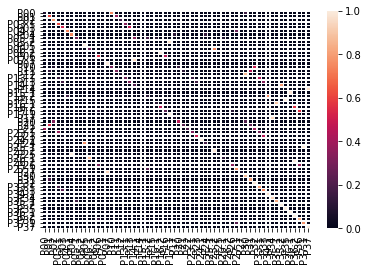

In [17]:

# perform rowwise normalisation on mapping_adj
prop_names = [myP.name for myP in network.memory.Ps]
vis_mappings(mapping_mat=mapping_adj,prop_names=prop_names)
error_val = mapping_error(mapping_mat=mapping_adj)
print(error_val)

In [66]:
baseline_mapping = np.ones((mapping_adj.shape))
baseline_mapping[:,:] = 1.0/baseline_mapping.shape[0]
print get_metrics(baseline_mapping)

(0.049999999999999836, 0.049999999999999906, 0.04999999999999987, 0.07080881928749333)


In [79]:
fscores

[0.4000000000000001,
 0.4375,
 0.6337328644363107,
 0.6035551089869626,
 0.5064687884713412,
 0.5064687884713412,
 0.47924027965736427,
 0.4806719845085805,
 0.5414327449004303,
 0.6127291650709782,
 0.6471813519355891,
 0.6171064471083999,
 0.6899425377854301,
 0.7161314649555358,
 0.741826323266087,
 0.737459821684969,
 0.713484484073379,
 0.7111636659949581,
 0.7307285210737448,
 0.665263522648325,
 0.6559359226041912,
 0.6559359226041913,
 0.6725381499652975,
 0.6649847400274748,
 0.6819925250792616,
 0.6838413242697144,
 0.6723068766256425,
 0.666584423671295,
 0.6666010392284946,
 0.7001521597505246,
 0.7212593932432206,
 0.7138275297966462,
 0.7085144179755228,
 0.7065419980572522,
 0.7065419980572522,
 0.7457943312826552,
 0.7492603398881007,
 0.7821821163478625,
 0.7821821163478625,
 0.763580002123081,
 0.7466883148553946,
 0.7450116815785532,
 0.7453883245852995,
 0.7470587873766362,
 0.7369268659457637,
 0.7453130502026909,
 0.7501780662881672,
 0.7449345846407733,
 0.730607

In [ ]:
get_metrics(mapping_mat = mapping_adj)

# Trials
## The kinds of tests that have been done and their results :

1. Keeping the object hanging (no predicate for object) means the RB is not created for the corresponding object. Weird.

1.1 Making the predicate a one-hot semantic perhaps? - Does not work

1.2 Making the predicate an empty semantic? - Does not work

1.3 Making the predicate a one-hot semantic that is orthogonal to other vectors? still noisy

2. Keeping the predicate hanging (no object for predicate)


3. Making the words 1 hot representations of their lexical properties, so here subject nouns, object nouns have a 1 hot rep, verbs, complemnetizer verbs, adjectives - Does MUCH BETTER. Promising results, but why are the mappings not perfect still?

3.1 Increase/decrease eta - nope - only makes existing connections stronger/weaker

3.2 gamma/delta/Hebbbias - (currently 0.3, .1, .5)

3.3 Don't ignore object semantics, and keep asDORA True - works better than 3.0

3.4 Try changing the predicate to the noun and keep the object empty - worked fine

4. Added loss metric. Now retry for all previous analysis - 100 runs

4.1 with one_to_one=True and max_norm=False, asDORA = True, ignore_object_sem = False, RMSE = 0.09

4.2 with one_to_one=True and max_norm=True, asDORA = True, ignore_objetct_sem=False, RMSE = 0.05 (def looks better)

4.3 try to use WordGCN and RMSE = .14

4.4 baseline_mapping RMSE = 0.103 (better than wordGCN :O )

4.5 setting embedding dimension = 5, and testing for simple word2vec model, RMSE = 0.12 (still worse than baseline)

5. Understanding object/predicate semantic usage :

5.3 strategic mapping has to be True for asDORA == False ( see do_mapping() )

5.4 Try with new semantic update - previous update was non linear max norm update. New update uses only link weight * parent act - RMSE = 

5.5 Try with new semantic update - added one hot semantic to empty object to distinguish it from other semantics, made sure ignore_object_semantics does not do what it should in the update_semantic code. 
RMSE = 0.098

5.6 Try with making predicate empty rather than object, RMSE = 0.108 :/ 

## Firing order similarity analysis : 

To make mapping more efficient, we have to consider firing order similarity in the mix. To make things easy, we have the firing order of the propositions in the driver. This is given by the ordering of the RBs themselves. 

To downweight/upweight the existing mapping connections, we need to consider the following :

5.1 We consider mappings in RBs and above. Therefore for every RB in the driver, we take a look at the POs that are connected to it in the driver, and the RB it maps to in the recipient, and its POs in the Recipient.

5.2 The mapping connection between RBs is upweighted if the indices of its POs match. Ex - RB1 maps to RB2 with weight w. PO11 and PO12 are the POs connected to RB1, and PO21 and PO22 are the POs connected to RB2. index(PO11), index(PO12), index(PO21), index(PO22) indicate where they appear in the RBs. Spearman Rank correlation between them should point to how similar they are. 

## Stuff to do : 

1. First, collect all mapping hypotheses in one place. This consists of all connections from Driver propositions to all recipient tokens of same type.

1.1 Don't break it now, but the Luce's choice algorithm is a bit weird. Gotta see why they use it. - instead of random threshold to retrieve analogs, use a fixed threshold = 0.1 currently

1.2 with threshold = 0.1, biasing proposition length as well, RMSE = 0.11 - looks bad. Got to find out a way to include RB firing order instead. 

1.3 Make sure P in parent is mapped to P in parent only. 

1.4 After taking out the one to one mapping constraint, mappings improve. - RMSE = 0.0853, set parent_bias = 0.5! 

1.5 setting parent_bias = 0.1 , 0.088 (not significant enough imo)

1.6 see how firing order similarity is affecting mapping coeff. Currently, mapping is in SSL, guided by a simple Hebbian learning rule that has coactivation as its basis. added correlations between activations to update_hyp. Correlations + one_to_one == True, RMSE = 0.067, one_to_one == False, RMSE = 0.077 (higher rmse :O )

1.7 Something to test out - parent and child modes need to be updated based on presence of parentRBs, not activations alons, nah? 

1.8 Run with larger prop number

1.9 Non recursive correlational mapping - 0.111

2.0 Firing by POs, mapping not reset after each run (god knows why that was being done in the first place)

2.1 Why does retrieval by bias_analog work so strangely? 

## Results - 

1.1 Collect RMSE over time, and plot the evolution
1.2 Comparison across word embedding strategies used
1.3 Record RB firing for proposition 0 in Ding stimuli style
